Copyright (c) Meta Platforms, Inc. and affiliates.
This software may be used and distributed according to the terms of the Llama 2 Community License Agreement.

<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PEFT Finetuning Quick Start Notebook

This notebook shows how to train a Meta Llama 3 model on a single GPU (e.g. A10 with 24GB) using int8 quantization and LoRA finetuning.

**_Note:_** To run this notebook on a machine with less than 24GB VRAM (e.g. T4 with 16GB) the context length of the training dataset needs to be adapted.
We do this based on the available VRAM during execution.
If you run into OOM issues try to further lower the value of train_config.context_length.

### Step 0: Install pre-requirements and convert checkpoint

We need to have llama-recipes and its dependencies installed for this notebook. Additionally, we need to log in with the huggingface_cli and make sure that the account is able to to access the Meta Llama weights.

In [1]:
# conda create -n ladlm_v1 python=3.11
# !conda install -y pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [2]:
# uncomment if running from Colab T4
# ! pip install llama-recipes ipywidgets

In [3]:
# !pip install huggingface_hub

In [4]:
from huggingface_hub import login
# login() 

### Step 1: Load the model

Setup training configuration and load the model and tokenizer.

In [1]:
import torch
from transformers import MllamaForConditionalGeneration, AutoTokenizer, AutoProcessor
from llama_recipes.configs import train_config as TRAIN_CONFIG

train_config = TRAIN_CONFIG()
train_config.model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
train_config.num_epochs = 3
train_config.run_validation = False
train_config.gradient_accumulation_steps = 8
train_config.batch_size_training = 1
train_config.lr = 3e-4
train_config.use_fast_kernels = True
train_config.use_fp16 = True
train_config.context_length = 256 if torch.cuda.get_device_properties(0).total_memory < 16e9 else 1024 # T4 16GB or A10 24GB
train_config.batching_strategy = "packing"
train_config.output_dir = "ladlm_v2"
train_config.use_peft = True

from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)


model = MllamaForConditionalGeneration.from_pretrained(
            train_config.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
        )
processor = AutoProcessor.from_pretrained(train_config.model_name)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

### Step 2: Check base model

Run the base model on an example input:

We can see that the base model only repeats the conversation.

### Step 3: Load the preprocessed dataset

We load and preprocess the samsum dataset which consists of curated pairs of dialogs and their summarization:

In [2]:
import ladlm_dataset
from torch.utils.data import DataLoader

# Train/Test 데이터셋 로드
train_dataset = ladlm_dataset.get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="train",
    split_ratio=0.9
)

eval_dataset = ladlm_dataset.get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="test",
    split_ratio=0.9
)

# Data Collator 생성
data_collator = ladlm_dataset.get_data_collator(processor)

# DataLoader 생성
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=True
)

eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=False
)

print(f"Train DataLoader and Eval DataLoader ready!")



Train DataLoader and Eval DataLoader ready!


### Step 4: Prepare model for PEFT

Let's prepare the model for Parameter Efficient Fine Tuning (PEFT):

In [4]:
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig
from dataclasses import asdict
from llama_recipes.configs import lora_config as LORA_CONFIG

from peft import PeftModel

# LoRA 모델 로드
lora_model = PeftModel.from_pretrained(model, train_config.output_dir)

### Step 7:
Try the fine tuned model on the same example again to see the learning progress:

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. Plot parameters: {'figsize': ['5.12', '5.12'], 'dpi': 100, 'file_format': 'png'}.
Explanation about spectrogram:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The distribution shows a gradual decrease in energy, resembling a hill formed around the 6s mark. There is a strong energy distribution across the entire range from 4s to 8s, particularly noticeable in the 4s-5.5s range at 6-8 kHz, which sounds reminiscent of wind (or the flapping of bat wings).<|eot_id|>


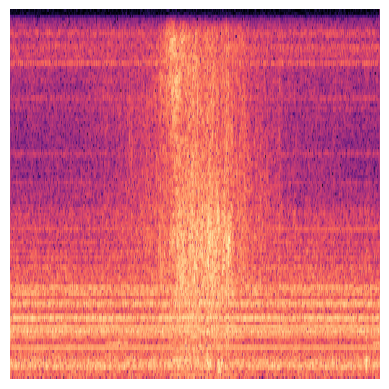

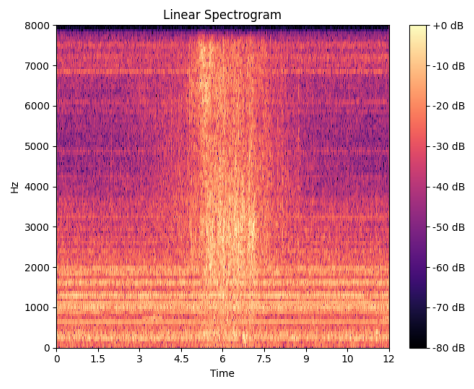

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# 모델을 평가 모드로 전환
model.eval()

# 테스트 데이터셋의 첫 번째 샘플 가져오기
sample = eval_dataset[1]


# 첫 번째 샘플의 이미지와 텍스트 추출
file_name = sample['file_name']

linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")

librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']

domain = sample['domain']              
type = sample['type']                  
machineType = sample['machineType']    
explanation_about_spectrogram = sample['explanation_about_spectrogram']


messages = [
    [
        {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text",
                "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                        f"The parameters used to extract this image are as follows: {librosa_parameters}. "
                        f"Plot parameters: {plot_parameters}.\nExplanation about spectrogram:"}
        ]},
    ]
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    linear_spectrogram_no_axes_image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

# # 입력을 모델이 있는 디바이스로 이동
# inputs = {key: value.to(model.device) for key, value in inputs.items()}

# 인퍼런스 수행
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=128)

print(processor.decode(output[0]))

# 이미지 표시 (선택 사항)
# plt.imshow(linear_spectrogram_no_axes_image)
# plt.axis('off')
# plt.show()

plt.imshow(linear_spectrogram_with_axes_image)
plt.axis('off')
plt.show()

In [ ]:
import os
from PIL import Image as PILImage
from openpyxl import Workbook
from openpyxl.drawing.image import Image as ExcelImage
import matplotlib.pyplot as plt
import torch

# 엑셀 파일 생성
output_excel = f"{train_config.output_dir}evaluation_results.xlsx"
wb = Workbook()
ws = wb.active
ws.title = "Evaluation Results"

# 열 헤더 설정
headers = [
    "File Name", "Domain", "Type", "Machine Type",
    "Explanation About Spectrogram", "Generated Text", "Spectrogram Image"
]
ws.append(headers)

# 평가 데이터셋 처리 루프
for i, sample in enumerate(eval_dataset):
    file_name = sample['file_name']
    linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
    linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")
    librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
    plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']
    domain = sample['domain']
    type_ = sample['type']
    machineType = sample['machineType']
    explanation_about_spectrogram = sample['explanation_about_spectrogram']

    # 메시지 생성
    messages = [
        [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text",
                        "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                                f"The parameters used to extract this image are as follows: {librosa_parameters}. "
                                f"Plot parameters: {plot_parameters}.\nExplanation about spectrogram:"}
                ]},
        ]
    ]

    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        linear_spectrogram_no_axes_image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    # 모델 생성
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=128)

    # Generated Text 디코딩 후 텍스트 정리
    generated_text = processor.decode(output[0])

    # '<|start_header_id|>assistant<|end_header_id|>' 이후의 텍스트만 추출
    if "<|start_header_id|>assistant<|end_header_id|>" in generated_text:
        generated_text = generated_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
    print(generated_text)

    # 플롯된 이미지 저장
    img_path = f"temp_image_{i}.png"
    plt.imshow(linear_spectrogram_with_axes_image)
    plt.axis('off')
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # 이미지 크기 확인
    with PILImage.open(img_path) as img:
        img_width, img_height = img.size

    # 엑셀 셀 크기 조정
    cell_width = img_width / 7  # 열 너비는 픽셀 크기의 1/7
    cell_height = img_height * 0.75  # 행 높이는 픽셀 크기의 0.75

    # 셀 크기 조정
    ws.column_dimensions['G'].width = max(ws.column_dimensions['G'].width or 0, cell_width)
    ws.row_dimensions[i + 2].height = cell_height

    # 엑셀에 데이터 추가
    ws.append([file_name, domain, type_, machineType, explanation_about_spectrogram, generated_text])

    # 이미지 삽입
    img = ExcelImage(img_path)
    img.anchor = f"G{i + 2}"  # 엑셀 셀 위치 지정 (헤더가 1줄 차지하므로 2부터 시작)
    ws.add_image(img)

# 엑셀 저장
wb.save(output_excel)

# 임시 이미지 파일 삭제
for i in range(len(eval_dataset)):
    img_path = f"temp_image_{i}.png"
    if os.path.exists(img_path):
        os.remove(img_path)

print(f"Evaluation results saved to {output_excel}")


Strong energy at low frequencies (2 kHz - 3 kHz). The intensity at high frequencies is very weak in the one-second intervals before and after.<|eot_id|>
There is a strong energy distribution across the entire frequency range prior to the 4s-8s interval, resembling the sound of wind or the fluttering of bat wings. A very thin yet strong vertical linear pattern is observed, radiating from the central frequency at intervals of 0.1s, accompanied by a tapping sound. Additionally, there is a strong energy distribution in the central frequency range (4s-8s), which sounds reminiscent of wind or the flapping of bat wings.<|eot_id|>
Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak in the one second before and after.<|eot_id|>
At high frequencies, the intensity is weak for one second before and after. At low frequencies (0 kHz - 1 kHz), there is strong energy.<|eot_id|>
Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequenc